In [ ]:
import numpy as np
import math
from keras.datasets import mnist
from keras.utils import to_categorical
import time
import matplotlib.pyplot as plt

In [ ]:
def initialize_parameters(layers_dim):
    weight_dict = {}
    for i in range(1,len(layers_dim)):
        weight_dict['W' + str(i)] = np.random.uniform(-(1 / np.sqrt(layers_dim[i])), 1 / np.sqrt(layers_dim[i]),  (layers_dim[i], layers_dim[i - 1]))
        weight_dict['b' + str(i)] = np.zeros((layers_dim[i], 1))

    return weight_dict

In [ ]:
def linear_forward(A,W,b):
    Z = np.dot(W,A) + b
    linear_cache = (A, W, b)
    return Z, linear_cache

In [ ]:
def softmax(Z):
    A = np.exp(Z) / np.sum(np.exp(Z), axis=0)
    activation_cache = Z
    return A, activation_cache

def relu(Z):
    A  = np.maximum(0,Z)
    activation_cache = Z
    return A, activation_cache

In [ ]:
def linear_activation_forward(A_prev, W, b, activation):
    Z,linear_cache = linear_forward(A_prev, W, b)
    if activation == "relu":
        A, activation_cache = relu(Z)
    elif activation == "softmax":
        A, activation_cache = softmax(Z)
    cache = (linear_cache, activation_cache)
    return A,cache


In [ ]:
def L_model_forward(X, weights_dict,use_batchnorm = False):
    A = X
    caches = []
    layers_num = len(weights_dict)//2
    for l in range(1,layers_num):
        A_prev = A
        A, cache = linear_activation_forward(A_prev, weights_dict['W' + str(l)], weights_dict['b' + str(l)],activation ="relu")
        if use_batchnorm:
            A = batchnorm(A)
        caches.append(cache)
    AL,cache = linear_activation_forward(A, weights_dict['W' + str(l+1)], weights_dict['b' + str(l+1)],    activation= 'softmax')
    caches.append(cache)
    return AL, caches


In [ ]:
def compute_cost(AL,Y):
    m = Y.shape[1]
    eps = 1e-9
    pred = np.clip(AL, eps, 1. - eps)
    cost = -1/m * np.sum(Y * np.log(pred))
    return cost


In [ ]:
def batchnorm(A):
    std = np.std(A.T, axis=0)
    means = np.mean(A.T, axis=0)
    avoid_zero_division = 0.00001
    NA  = (A.T - means) / (std + avoid_zero_division)
    return NA.T

In [ ]:
def linear_backward(dZ, cache):
    A_prev,W,b  = cache
    m = A_prev.shape[1]
    dW = 1/m * np.dot(dZ,A_prev.T)
    db = 1/m * np.sum(dZ,axis=1,keepdims=True)
    dA_prev = np.dot(W.T,dZ)
    return dA_prev, dW, db

In [ ]:
def linear_activation_backward(dA,cache,activation):
    linear_cache,activation_cache = cache
    if activation == "relu":
        dZ = relu_backward(dA, activation_cache)
    elif activation == "softmax":
        dZ = softmax_backward(dA, activation_cache)

    dA_prev, dW, db = linear_backward(dZ, linear_cache)
    return dA_prev, dW, db


def softmax_backward(dA, activation_cache):
    Z = activation_cache
    T = np.exp(Z)
    A = T / np.sum(T, axis=0)
    dZ  = dA * A * (1 - A)
    return dZ

def relu_backward(dA, activation_cache):
    dA[activation_cache <= 0] = 0
    return dA


In [ ]:
def L_model_backward(AL, Y, caches):
    num_layers = len(caches)
    m = AL.shape[1]
    grads = {}
    Y = Y.reshape(AL.shape)
    dAL = - (np.divide(Y, AL) - np.divide(1 - Y, 1 - AL))
    last_cache = caches[-1]
    grads["dA" + str(num_layers)], grads["dW" + str(num_layers)], grads["db" + str(num_layers)] = linear_activation_backward(dAL, last_cache, activation = "softmax")
    for i in reversed(range(num_layers-1)):
        last_cache = caches[i]
        dA_prev_temp, dW_temp,db_temp = linear_activation_backward(grads["dA" + str(i + 2)], last_cache, activation = "relu")
        grads["dA" + str(i + 1)],grads["dW" + str(i+1)],grads["db" + str(i+1)] = dA_prev_temp, dW_temp, db_temp
    return grads



In [ ]:
def update_parameters(weights_dict, grads, learning_rate,L2_norm = False):
    len_layers = len(weights_dict) // 2
    for l in range(1,len_layers+1):
        if L2_norm:
            weights_dict["W"+str(l)] = weights_dict["W"+str(l)] -learning_rate * (grads["dW" + str(l)]  + learning_rate * weights_dict["W"+str(l)])
        else:
            weights_dict["W"+str(l)] = weights_dict["W"+str(l)] -learning_rate * grads["dW" + str(l)]
        weights_dict["b"+str(l)] = weights_dict["b"+str(l)] -learning_rate * grads["db" + str(l)]
    return weights_dict


In [ ]:
def L_layer_model(X,Y,layers_dims,learning_rate,num_iterations,batch_size,use_batchnorm = False,L2_norm = False):
    X = X.T
    Y = Y.T
    indexes  = np.random.permutation(X.shape[0])
    current_accuracy = 0
    prev_accuracy = 0
    training_i, test_i = indexes[:math.ceil(0.8*X.shape[0])], indexes[math.ceil(0.8*X.shape[0]):]
    Y_train,Y_val = Y[training_i,:],Y[test_i,:]
    X_train,X_val = X[training_i,:],X[test_i,:]
    costs = []
    weights_dict = initialize_parameters(layers_dims)
    batch_num = math.ceil(X_train.shape[0]/batch_size)
    X_batches,Y_batches = [],[]
    stop = False
    batch_acc = 0
    for i in range(batch_num):
        X_batches.append(X_train[i*batch_size:(i+1)*batch_size,:].T)
        Y_batches.append(Y_train[i*batch_size:(i+1)*batch_size,:].T)
    for i in range(num_iterations):
        if not stop:
            for j in range(len(X_batches)):
                AL,caches = L_model_forward(X_batches[j],weights_dict,use_batchnorm)
                grads = L_model_backward(AL,Y_batches[j],caches)
                weights_dict = update_parameters(weights_dict,grads,learning_rate,L2_norm)
                batch_acc += 1
                if batch_acc % 100 == 0:
                    cost = compute_cost(AL,Y_batches[j])
                    if L2_norm:
                        for k in range(len(layers_dims)-1):
                            w = weights_dict["W"+str(k+1)]
                            cost = cost + (learning_rate/2) * np.sum(w * w)
                    costs.append(cost)
                    print(f'in batch {batch_acc}, in iteration number {i}, the cost is {cost}')
            current_accuracy = predict(X_val.T,Y_val.T,weights_dict,use_batchnorm)
            if current_accuracy - prev_accuracy < 0.00000001  :
                stop = True
                break
            prev_accuracy = current_accuracy
            training_accuracy = predict(X.T,Y.T,weights_dict,use_batchnorm)
    val_accuracy = predict(X_val.T,Y_val.T,weights_dict,use_batchnorm)
    print(f"training accuracy: {training_accuracy} validation accuracy: {val_accuracy} \\ took "+str(i+1)+ f"iterations and {batch_acc} batches")
    return weights_dict,costs,training_accuracy,val_accuracy


In [ ]:
def predict(X,Y,weights_dict,use_batchnorm):
    probab,_ = L_model_forward(X,weights_dict,use_batchnorm)
    correct = np.sum(np.argmax(probab,keepdims=True,axis = 0) == np.argmax(Y,keepdims = True,axis = 0))
    acc = correct/X.shape[1]
    return acc

In [ ]:
def preprocess_data(x, y):
    pre_y = to_categorical(y, 10)
    pre_y = pre_y.reshape(pre_y.shape[0], -1).T
    f_x = x.reshape(x.shape[0], -1).T / 255.
    return f_x, pre_y


In [ ]:
num_iterations = 100
batch_size = 100
use_batchnorm = False
L2_norm = False
learning_rate = 0.009
(x_train, y_train), (x_test, y_test) = mnist.load_data()
x_test, y_test = preprocess_data(x_test, y_test)
x_train, y_train = preprocess_data(x_train, y_train)
layers_dims = [x_train.shape[0],20,7,5,10]
time_start_a = time.time()
weights_dict_a,costs_a,training_accuracy_a,val_accuracy_a = L_layer_model(x_train, y_train, layers_dims,learning_rate, num_iterations, batch_size, use_batchnorm, L2_norm)
end_time_a = time.time()
elapsed_time_a = end_time_a - time_start_a
test_accuracy_a = predict(x_test,y_test,weights_dict_a,use_batchnorm)
use_batchnorm = True
start_time_batchnorm = time.time()
weights_dict_batchnorm,costs_batchnorm,training_accuracy_batchnorm,val_accuracy_batchnorm = L_layer_model(x_train, y_train, layers_dims, learning_rate, num_iterations, batch_size, use_batchnorm, L2_norm)
end_time_batchnorm = time.time()
elapsed_time_batchnorm = end_time_batchnorm - start_time_batchnorm
test_accuracy_batchnorm = predict(x_test,y_test,weights_dict_batchnorm,use_batchnorm)
use_batchnorm = False
L2_norm = True
start_time_L2 = time.time()
weights_dict_L2,costs_L2,training_accuracy_L2,val_accuracy_L2 = L_layer_model(x_train, y_train, layers_dims,learning_rate, num_iterations, batch_size, use_batchnorm, L2_norm)
end_time_L2 = time.time()
elapsed_time_L2 = end_time_L2 - start_time_L2
test_accuracy_L2 = predict(x_test,y_test,weights_dict_L2,use_batchnorm)
print("#################################################################################################################")
print("the results of the model without batchnorm or L2 norm")
print(f"train accuracy : {training_accuracy_a},validation accuracy is {val_accuracy_a}, test accuracy is {test_accuracy_a}")
print("#################################################################################################################")
print("the results of the model with batchnorm")
print(f"train accuracy : {training_accuracy_batchnorm},validation accuracy is {val_accuracy_batchnorm}, test accuracy is {test_accuracy_batchnorm}")
print("#################################################################################################################")
print("the results of the model with L2 norm")
print("#################################################################################################################")
print(f"train accuracy : {training_accuracy_L2},validation accuracy is {val_accuracy_L2}, test accuracy is {test_accuracy_L2}")
print(f"the time taken to train the model without batchnorm or L2 norm is {elapsed_time_a} seconds")
print(f"the time taken to train the model with batchnorm is {elapsed_time_batchnorm} seconds")
print(f"the time taken to train the model with L2 norm is {elapsed_time_L2} seconds")

weight_diff = np.sum(weights_dict_a['W1'] - weights_dict_L2['W1']) + np.sum(weights_dict_a['W2'] - weights_dict_L2['W2']) + np.sum(weights_dict_a['W3'] - weights_dict_L2['W3']) + np.sum(weights_dict_a['W4'] - weights_dict_L2['W4'])
print("the difference between the weights of the model without batchnorm or L2 norm and the model with L2 norm is " + str(weight_diff))

11490434/11490434 [==============================] - 0s 0us/step
in batch 100, in iteration number 0, the cost is 2.2910215174537134
in batch 200, in iteration number 0, the cost is 2.296793202357077
in batch 300, in iteration number 0, the cost is 2.2960298555236562
in batch 400, in iteration number 0, the cost is 2.2783783775056476
in batch 500, in iteration number 1, the cost is 2.2745398385702114
in batch 600, in iteration number 1, the cost is 2.2596217708698307
in batch 700, in iteration number 1, the cost is 2.2465793894011195
in batch 800, in iteration number 1, the cost is 2.2419420061222057
in batch 900, in iteration number 1, the cost is 2.2216169172106883
in batch 1000, in iteration number 2, the cost is 2.2021581355159876
in batch 1100, in iteration number 2, the cost is 2.1060995724312086
in batch 1200, in iteration number 2, the cost is 2.024259929998801
in batch 1300, in iteration number 2, the cost is 2.039646571557365
in batch 1400, in iteration number 2, the cost is 

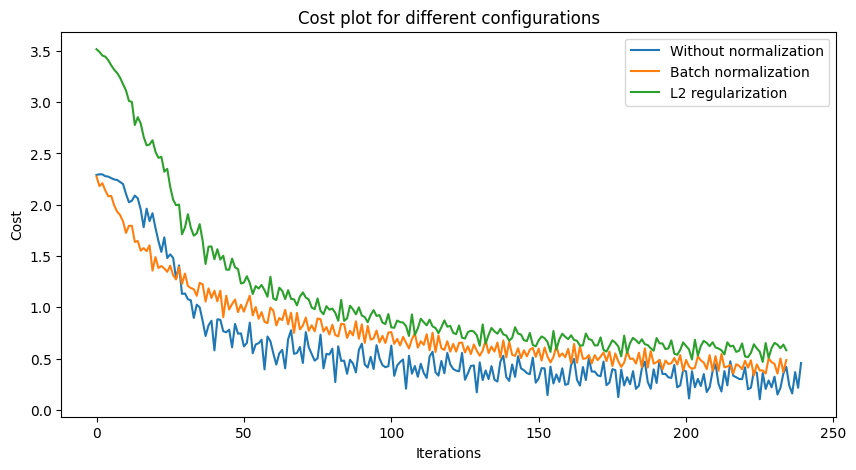

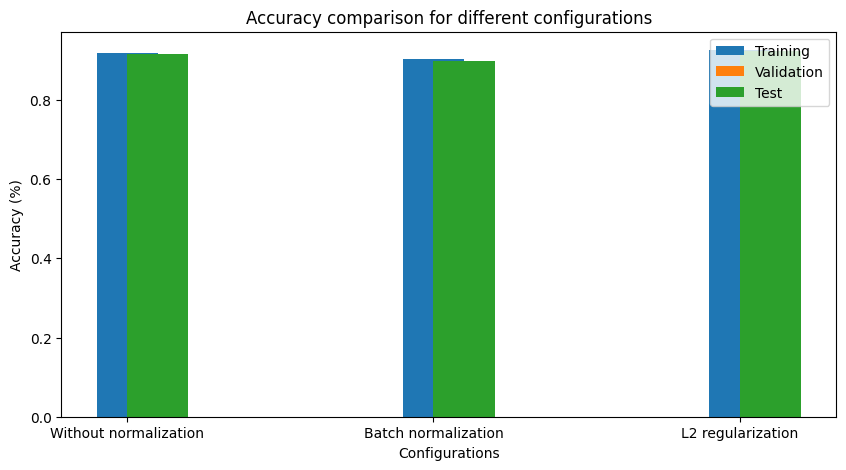

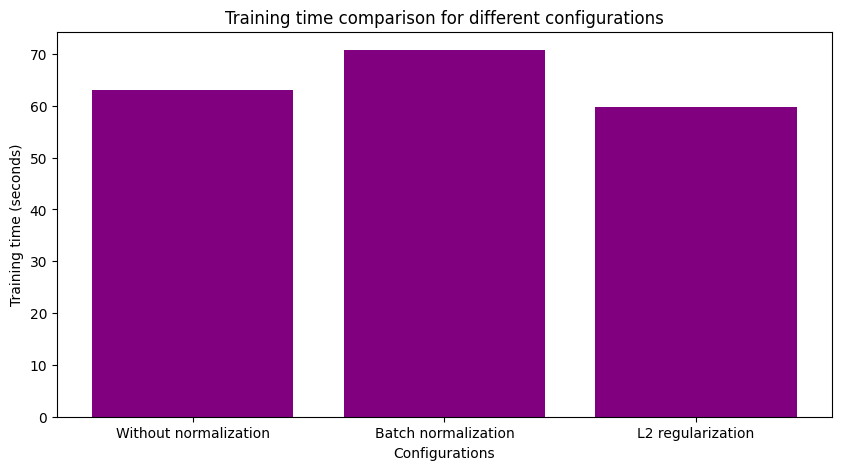

In [ ]:
# Visualization of results

# Visualization of costs
plt.figure(figsize=(10, 5))

plt.plot(costs_a, label='Without normalization')
plt.plot(costs_batchnorm, label='Batch normalization')
plt.plot(costs_L2, label='L2 regularization')

plt.xlabel('Iterations')
plt.ylabel('Cost')
plt.title('Cost plot for different configurations')
plt.legend()
plt.show()

# Visualization of accuracy
configurations = ['Without normalization', 'Batch normalization', 'L2 regularization']
training_accuracies = [training_accuracy_a, training_accuracy_batchnorm, training_accuracy_L2]
validation_accuracies = [val_accuracy_a, val_accuracy_batchnorm, val_accuracy_L2]
test_accuracies = [test_accuracy_a, test_accuracy_batchnorm, test_accuracy_L2]

x = range(len(configurations))

plt.figure(figsize=(10, 5))

plt.bar(x, training_accuracies, width=0.2, label='Training', align='center')
plt.bar(x, validation_accuracies, width=0.2, label='Validation', align='edge')
plt.bar(x, test_accuracies, width=0.2, label='Test', align='edge')

plt.xlabel('Configurations')
plt.ylabel('Accuracy (%)')
plt.title('Accuracy comparison for different configurations')
plt.xticks(x, configurations)
plt.legend()
plt.show()

# Visualization of training time
training_times = [elapsed_time_a, elapsed_time_batchnorm, elapsed_time_L2]

plt.figure(figsize=(10, 5))
plt.bar(configurations, training_times, color='purple')
plt.xlabel('Configurations')
plt.ylabel('Training time (seconds)')
plt.title('Training time comparison for different configurations')
plt.show()

## Conclusion
Graphs:

The graph **"Cost plot for different configurations"** shows how the cost (error) decreases with the increase in the number of iterations for each configuration.
It can be observed that L2 regularization leads to a more stable and rapid decrease in cost compared to the other configurations.

The graph **"Accuracy comparison for different configurations"** compares the accuracy on training, validation, and test datasets for each configuration.
The configuration with L2 regularization shows the highest accuracy across all datasets.
The configuration with batch normalization demonstrated the lowest accuracy compared to the other configurations.


The graph **"Training time comparison for different configurations"** shows the time taken to train each configuration.
The configuration with batch normalization took the longest time to train, whereas the configuration with L2 regularization was the fastest.

**Results:**

*Configuration without normalization:*

* Training accuracy: 91.90%
* Validation accuracy: 90.85%
* Test accuracy: 91.51%
* Training time: 63.01 seconds


*Configuration with batch normalization:*
* Training accuracy: 90.26%
* Validation accuracy: 89.83%
* Test accuracy: 89.74%
* Training time: 70.75 seconds


*Configuration with L2 regularization:*
* Training accuracy: 92.57%
* Validation accuracy: 91.98%
* Test accuracy: 92.21%
* Training time: 59.77 seconds



# **Conclusion:**
The experiment was conducted to compare three different neural network configurations:

* Without normalization
* With batch normalization
* With L2 regularization
Below are the results visualized in the graphs and obtained after executing the code.

The L2 regularization configuration showed the highest accuracy on the training, validation, and test datasets, as well as the most stable and rapid decrease in cost.

The batch normalization configuration showed the lowest accuracy and took the longest time to train compared to the other configurations.

The configuration without normalization performed well but was outperformed by the L2 regularization configuration in terms of accuracy and training speed.
Thus, for this task, based on the obtained results, the L2 regularization configuration is the most optimal, providing the highest accuracy and the shortest training time.